In [ ]:
import pandas as pd
import numpy as np

# STEP 1: Load dataset
df = pd.read_csv('/content/datasets/merged_paid_vs_organic_with_totals1.csv')
print("✅ Loaded dataset:", df.shape)



✅ Loaded dataset: (1665, 58)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# ─── 0) Assume df is your full DataFrame with those 10 rows (or more) ───

# ─── 1) Split into channel‐specific DataFrames ──────────────────────────
df_org = df[['canonical_keyword_x','TimePeriod',
             'Search Volume','Impressions_SEO','Blended Rank_SEO']].copy()

df_paid = df[['canonical_keyword_x','TimePeriod',
              'Paid_Clicks','Paid_Impressions','Paid_Cost','Paid_CTR']].copy()


# ─── 2) Organic preprocessing ──────────────────────────────────────────
# 2a) Invert rank so higher is better
max_rank = df_org['Blended Rank_SEO'].max()
df_org['Rank_inv'] = max_rank - df_org['Blended Rank_SEO']

# 2b) Log‐transform skewed volume & impressions
df_org['SearchVol_log']  = np.log1p(df_org['Search Volume'])
df_org['ImprSEO_log']    = np.log1p(df_org['Impressions_SEO'])

# 2c) Min–max scale
scaler_org = MinMaxScaler()
org_feats = ['SearchVol_log','ImprSEO_log','Rank_inv']
df_org[[f+'_norm' for f in org_feats]] = scaler_org.fit_transform(df_org[org_feats])

# 2d) Composite organic score
df_org['Organic_Score'] = df_org[[f+'_norm' for f in org_feats]].mean(axis=1)


# ─── 3) Paid preprocessing ─────────────────────────────────────────────
# 3a) Invert cost so lower spend → higher score
max_cost = df_paid['Paid_Cost'].max()
df_paid['Cost_inv'] = max_cost - df_paid['Paid_Cost']

# 3b) Log‐transform skewed features
df_paid['ClicksPaid_log'] = np.log1p(df_paid['Paid_Clicks'])
df_paid['ImprPaid_log']   = np.log1p(df_paid['Paid_Impressions'])
df_paid['Cost_inv_log']   = np.log1p(df_paid['Cost_inv'])
df_paid['CTR_log']        = np.log1p(df_paid['Paid_CTR'])

# 3c) Min–max scale
scaler_paid = MinMaxScaler()
paid_feats = ['ClicksPaid_log','ImprPaid_log','CTR_log','Cost_inv_log']
df_paid[[f+'_norm' for f in paid_feats]] = scaler_paid.fit_transform(df_paid[paid_feats])

# 3d) Composite paid score
df_paid['Paid_Score'] = df_paid[[f+'_norm' for f in paid_feats]].mean(axis=1)


# ─── 4) Cluster into 3 performance tiers ───────────────────────────────
def make_tiers(df_channel, score_col, prefix):
    # k-means on the single score dimension
    km = KMeans(n_clusters=3, random_state=42).fit(df_channel[[score_col]])
    centers = km.cluster_centers_.flatten()
    order   = np.argsort(centers)  # low→high
    mapping = {order[0]: 'Low', order[1]: 'Mid', order[2]: 'High'}
    df_channel[prefix + '_Tier'] = pd.Series(km.labels_).map(mapping)
    return df_channel

df_org   = make_tiers(df_org,  'Organic_Score', 'Org')
df_paid  = make_tiers(df_paid, 'Paid_Score',    'Paid')


# ─── 5) Merge tiers & scores back into one DataFrame ───────────────────
df_merged = pd.merge(df,
                     df_org[['canonical_keyword_x','TimePeriod','Organic_Score','Org_Tier']],
                     on=['canonical_keyword_x','TimePeriod'],
                     how='left')

df_merged = pd.merge(df_merged,
                     df_paid[['canonical_keyword_x','TimePeriod','Paid_Score','Paid_Tier']],
                     on=['canonical_keyword_x','TimePeriod'],
                     how='left')


# ─── 6) Example: extract low-hanging fruit per channel ─────────────────
# (High organic but Low paid → pull back on ads / invest organic)
org_opps  = df_merged[(df_merged.Org_Tier=='High') & (df_merged.Paid_Tier=='Low')]

# (High paid but Low organic → optimize paid or add SEO)
paid_opps = df_merged[(df_merged.Paid_Tier=='High') & (df_merged.Org_Tier=='Low')]

# ─── 7) Inspect
print("Organic opps:\n", org_opps[['canonical_keyword_x','Org_Tier','Paid_Tier']])
print("\nPaid    opps:\n", paid_opps[['canonical_keyword_x','Org_Tier','Paid_Tier']])


Organic opps:
                  canonical_keyword_x Org_Tier Paid_Tier
17                   flammable label     High       Low
81                      imdg code 38     High       Low
204                     imdg code 38     High       Low
293                  flammable label     High       Low
859                     un3481 label     High       Low
945                   battery un3480     High       Low
1153                    un3091 label     High       Low
1210                    un3481 label     High       Low
1274                    un3091 label     High       Low
1309                        2012 erg     High       Low
1325                    un3481 label     High       Low
1369                    un3091 label     High       Low
1443                  battery un3480     High       Low
1445                   un 3480 label     High       Low
1460                    un3481 label     High       Low
1486                    un3091 label     High       Low
1534                  battery un3

In [ ]:
# Save the merged results to CSV
output_file = 'keyword_performance_tiers.csv'
df_merged.to_csv(output_file, index=False)
print(f"Saved merged results to {output_file}")


Saved merged results to keyword_performance_tiers.csv


In [ ]:
# 1) Define a function that maps Org/Paid tiers into business‐friendly labels
def classify_business(row):
    if row['Org_Tier'] == 'High' and row['Paid_Tier'] == 'Low':
        return "Strong in SEO vs Paid – consider pulling back paid spend"
    elif row['Org_Tier'] == 'Low' and row['Paid_Tier'] == 'High':
        return "Needs Organic Improvement – invest in SEO"
    elif row['Org_Tier'] == 'High' and row['Paid_Tier'] == 'High':
        return "Keep Paying + Invest Organic – dual‐channel focus"
    else:
        return "Low in Both Channels – reevaluate keyword priority"

# 2) Apply it to your merged DataFrame
df_merged['Business_Class'] = df_merged.apply(classify_business, axis=1)

# 3) Inspect the first few classifications
print(df_merged[['canonical_keyword_x','Org_Tier','Paid_Tier','Business_Class']].head())

# 4) (Optional) Save the new classification as CSV
df_merged.to_csv('keyword_business_classification.csv', index=False)
print("Saved business classifications to keyword_business_classification.csv")


                   canonical_keyword_x Org_Tier Paid_Tier  \
0        emergency response guide book      Mid       Mid   
1         emergency response guidebook     High      High   
2            how to ship a car battery      Mid       Mid   
3                hazardous waste label     High       Mid   
4  dangerous good declaration software      Mid       Low   

                                      Business_Class  
0  Low in Both Channels – reevaluate keyword prio...  
1  Keep Paying + Invest Organic – dual‐channel focus  
2  Low in Both Channels – reevaluate keyword prio...  
3  Low in Both Channels – reevaluate keyword prio...  
4  Low in Both Channels – reevaluate keyword prio...  
Saved business classifications to keyword_business_classification.csv


In [ ]:
# 1) Drop the unwanted columns
cols_to_drop = [
    'Keyword',
    'mapped_canonical',
    'Search keyword',
    'Search keyword match type'
]
df_final = df_merged.drop(columns=cols_to_drop)

# 2) Save to CSV
output_file = 'keyword_business_classification_final.csv'
df_final.to_csv(output_file, index=False)
print(f"Saved final dataset (without unwanted columns) to {output_file}")


Saved final dataset (without unwanted columns) to keyword_business_classification_final.csv


In [ ]:
# Compute and print the count of each business classification
label_counts = df_final['Business_Class'].value_counts()
print(label_counts)


Business_Class
Low in Both Channels – reevaluate keyword priority          1326
Keep Paying + Invest Organic – dual‐channel focus            286
Needs Organic Improvement – invest in SEO                     35
Strong in SEO vs Paid – consider pulling back paid spend      18
Name: count, dtype: int64


In [ ]:
# 1) Create a “scores only” DataFrame
df_scores = df_merged.drop(columns=[
    'Org_Tier', 'Paid_Tier', 'Business_Class'
])

# 2) (Optional) Inspect basic statistics to pick thresholds manually
print(df_scores[['Organic_Score', 'Paid_Score']].describe())
# Or deciles:
import numpy as np
print("Organic deciles:\n", df_scores['Organic_Score'].quantile(np.arange(0,1.01,0.1)))
print("Paid    deciles:\n", df_scores['Paid_Score'].quantile(np.arange(0,1.01,0.1)))


       Organic_Score   Paid_Score
count    1665.000000  1665.000000
mean        0.536211     0.602286
std         0.158059     0.118956
min         0.010526     0.250000
25%         0.432942     0.531521
50%         0.532664     0.609751
75%         0.644358     0.680807
max         0.994152     0.920220
Organic deciles:
 0.0    0.010526
0.1    0.326514
0.2    0.404364
0.3    0.462234
0.4    0.497097
0.5    0.532664
0.6    0.575987
0.7    0.617507
0.8    0.679087
0.9    0.756428
1.0    0.994152
Name: Organic_Score, dtype: float64
Paid    deciles:
 0.0    0.250000
0.1    0.455982
0.2    0.511105
0.3    0.548356
0.4    0.581511
0.5    0.609751
0.6    0.636911
0.7    0.665589
0.8    0.697271
0.9    0.740302
1.0    0.920220
Name: Paid_Score, dtype: float64


Organic_Score deciles:
 0.0    0.010526
0.1    0.326514
0.2    0.404364
0.3    0.462234
0.4    0.497097
0.5    0.532664
0.6    0.575987
0.7    0.617507
0.8    0.679087
0.9    0.756428
1.0    0.994152
Name: Organic_Score, dtype: float64

Paid_Score deciles:
 0.0    0.250000
0.1    0.455982
0.2    0.511105
0.3    0.548356
0.4    0.581511
0.5    0.609751
0.6    0.636911
0.7    0.665589
0.8    0.697271
0.9    0.740302
1.0    0.920220
Name: Paid_Score, dtype: float64


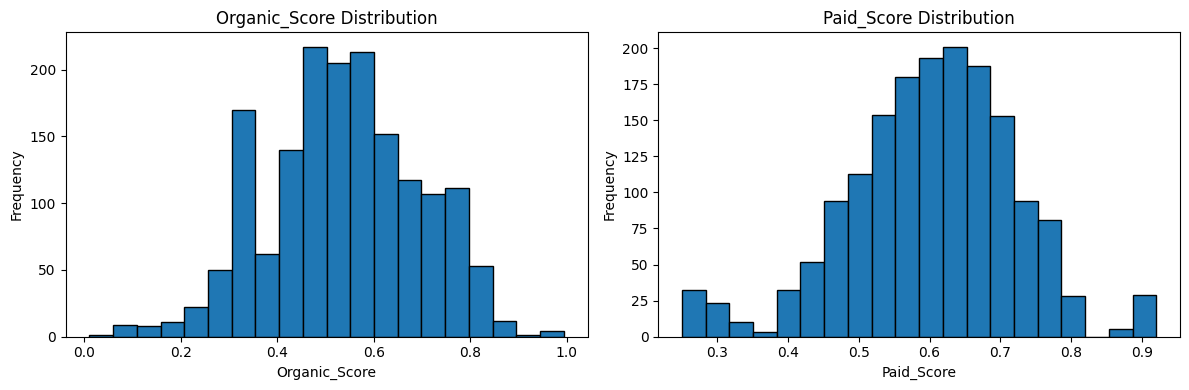

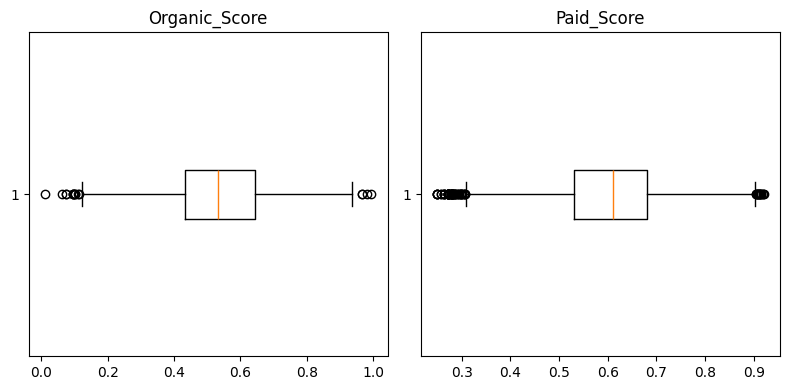

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Print deciles again for reference
print("Organic_Score deciles:\n", df_final['Organic_Score'].quantile(np.arange(0,1.01,0.1)))
print("\nPaid_Score deciles:\n",    df_final['Paid_Score'].quantile(np.arange(0,1.01,0.1)))

# 2) Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].hist(df_final['Organic_Score'], bins=20, edgecolor='black')
axes[0].set_title('Organic_Score Distribution')
axes[0].set_xlabel('Organic_Score')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_final['Paid_Score'], bins=20, edgecolor='black')
axes[1].set_title('Paid_Score Distribution')
axes[1].set_xlabel('Paid_Score')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3) (Optional) Boxplots to see outliers
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].boxplot(df_final['Organic_Score'], vert=False)
axes[0].set_title('Organic_Score')
axes[1].boxplot(df_final['Paid_Score'], vert=False)
axes[1].set_title('Paid_Score')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# 1) Re-use your thresholds (adjust as needed)
org_thr  = df_final['Organic_Score'].quantile(0.75)
paid_thr = df_final['Paid_Score'].quantile(0.75)

# 2) Flag strong vs weak in each channel
df_final['org_strong']  = df_final['Organic_Score'] >= org_thr
df_final['paid_strong'] = df_final['Paid_Score']    >= paid_thr

# 3) Four-way labeling
def label_kw(row):
    if   row['org_strong'] and row['paid_strong']:
        return "Strong in both → cut/reduce paid"
    elif row['org_strong'] and not row['paid_strong']:
        return "Strong in organic, not paid → invest in paid"
    elif not row['org_strong'] and row['paid_strong']:
        return "Strong in paid, not organic → invest in organic"
    else:
        return "Weak in both channels"

df_final['Business_Label_4'] = df_final.apply(label_kw, axis=1)

# 4) Check counts
print(df_final['Business_Label_4'].value_counts())


Business_Label_4
Weak in both channels                              1038
Strong in organic, not paid → invest in paid        210
Strong in paid, not organic → invest in organic     210
Strong in both → cut/reduce paid                    207
Name: count, dtype: int64


In [ ]:
import numpy as np

# 1) Pull out the “Weak in both channels” subset
weak = df_final[df_final['Business_Label_4']=='Weak in both channels'].copy()

# 2) Compute a combined score to rank them
weak['Combined_Score'] = weak[['Organic_Score','Paid_Score']].mean(axis=1)

# 3) Decide how many buckets you want; here we’ll do 3 (low/med/high within “weak”)
q_low, q_high = weak['Combined_Score'].quantile([0.33, 0.66])

# 4) Assign a sub‐label based on those tertiles
def assign_weak_sub(cs):
    if cs <= q_low:
        return 'Weak-Both: Very Low'
    elif cs <= q_high:
        return 'Weak-Both: Moderate'
    else:
        return 'Weak-Both: Near Threshold'

weak['Weak_Subclass'] = weak['Combined_Score'].apply(assign_weak_sub)

# 5) View the distribution
print(weak['Weak_Subclass'].value_counts())


Weak_Subclass
Weak-Both: Near Threshold    353
Weak-Both: Very Low          343
Weak-Both: Moderate          342
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd

# 1) Recompute the weak‐subset and its subclass if it's missing
weak = df_final[df_final['Business_Label_4'] == 'Weak in both channels'].copy()
weak['Combined_Score'] = weak[['Organic_Score','Paid_Score']].mean(axis=1)

# 2) Compute tertile cut‐points
q_low, q_high = weak['Combined_Score'].quantile([0.33, 0.66])

# 3) Assign Weak_Subclass based on those tertiles
weak['Weak_Subclass'] = pd.cut(
    weak['Combined_Score'],
    bins=[-np.inf, q_low, q_high, np.inf],
    labels=['Weak-Both: Very Low', 'Weak-Both: Moderate', 'Weak-Both: Near Threshold']
)

# 4) Merge Weak_Subclass back into df_final
df_final = df_final.merge(
    weak[['canonical_keyword_x','TimePeriod','Weak_Subclass']],
    on=['canonical_keyword_x','TimePeriod'],
    how='left'
)

# 5) Now apply your final 7‐way labeling
def final_business_label(row):
    lbl = row['Business_Label_4']
    if lbl != 'Weak in both channels':
        return lbl
    sub = row['Weak_Subclass']
    if sub == 'Weak-Both: Near Threshold':
        return 'Weak near thresholds – small optimizations'
    elif sub == 'Weak-Both: Moderate':
        return 'Weak moderate – deprioritize but monitor'
    elif sub == 'Weak-Both: Very Low':
        return 'Weak very low – drop or archive'
    else:
        return lbl

df_final['Business_Label_Final'] = df_final.apply(final_business_label, axis=1)

# 6) Check the new breakdown
print(df_final['Business_Label_Final'].value_counts())


Business_Label_Final
Weak near thresholds – small optimizations         353
Weak very low – drop or archive                    343
Weak moderate – deprioritize but monitor           342
Strong in organic, not paid → invest in paid       210
Strong in paid, not organic → invest in organic    210
Strong in both → cut/reduce paid                   207
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd

# 1) Set your new percentile thresholds here
org_pctile  = 0.70   # e.g. top 70% for “strong” organic
paid_pctile = 0.70   # e.g. top 70% for “strong” paid

# 2) Compute the actual score cut-offs
org_thr  = df_final['Organic_Score'].quantile(org_pctile)
paid_thr = df_final['Paid_Score'].quantile(paid_pctile)

# 3) Re-label the four main buckets
df_final['org_strong']  = df_final['Organic_Score'] >= org_thr
df_final['paid_strong'] = df_final['Paid_Score']    >= paid_thr

def label_4way(row):
    if   row['org_strong'] and row['paid_strong']:
        return "Strong in both → cut/reduce paid"
    elif row['org_strong'] and not row['paid_strong']:
        return "Strong in organic, not paid → invest in paid"
    elif not row['org_strong'] and row['paid_strong']:
        return "Strong in paid, not organic → invest in organic"
    else:
        return "Weak in both channels"

df_final['Business_Label_4'] = df_final.apply(label_4way, axis=1)

# 4) Re-split the “Weak in both channels” group into tertiles
weak = df_final[df_final['Business_Label_4']=='Weak in both channels'].copy()
weak['Combined_Score'] = weak[['Organic_Score','Paid_Score']].mean(axis=1)
q_low, q_high = weak['Combined_Score'].quantile([0.33, 0.66])
weak['Weak_Subclass'] = pd.cut(
    weak['Combined_Score'],
    bins=[-np.inf, q_low, q_high, np.inf],
    labels=['Weak-Both: Very Low','Weak-Both: Moderate','Weak-Both: Near Threshold']
)

# 5) Merge the subclass back in
df_final = df_final.drop(columns=['Weak_Subclass'], errors='ignore')  # remove old if exists
df_final = df_final.merge(
    weak[['canonical_keyword_x','TimePeriod','Weak_Subclass']],
    on=['canonical_keyword_x','TimePeriod'],
    how='left'
)

# 6) Generate the final 7‐way labels
def label_final(row):
    lbl = row['Business_Label_4']
    if lbl != 'Weak in both channels':
        return lbl
    sub = row['Weak_Subclass']
    if sub == 'Weak-Both: Near Threshold':
        return 'Weak near thresholds – small optimizations'
    elif sub == 'Weak-Both: Moderate':
        return 'Weak moderate – deprioritize but monitor'
    elif sub == 'Weak-Both: Very Low':
        return 'Weak very low – drop or archive'
    return lbl

df_final['Business_Label_Final'] = df_final.apply(label_final, axis=1)

# 7) Inspect your new distribution
print(df_final['Business_Label_Final'].value_counts())


Business_Label_Final
Weak near thresholds – small optimizations         319
Weak moderate – deprioritize but monitor           310
Weak very low – drop or archive                    310
Strong in both → cut/reduce paid                   274
Strong in organic, not paid → invest in paid       226
Strong in paid, not organic → invest in organic    226
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import classification_report, confusion_matrix

# 1) Features & target
X = df_final[['Organic_Score','Paid_Score']]
y = df_final['Business_Label_Final']

# 2) Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 3) Train
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 4) Evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=clf.classes_, columns=clf.classes_
))

# 5) 5-fold CV accuracy
cv = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"\n5-fold CV Accuracy: {cv.mean():.3f} ± {cv.std():.3f}")

# 6) Feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns)
print("\nFeature importances:\n", importances.sort_values(ascending=False))



Classification Report:

                                                 precision    recall  f1-score   support

               Strong in both → cut/reduce paid       1.00      1.00      1.00        82
   Strong in organic, not paid → invest in paid       1.00      0.99      0.99        68
Strong in paid, not organic → invest in organic       1.00      1.00      1.00        68
       Weak moderate – deprioritize but monitor       0.98      0.95      0.96        93
     Weak near thresholds – small optimizations       0.96      0.99      0.97        96
                Weak very low – drop or archive       0.98      0.99      0.98        93

                                       accuracy                           0.98       500
                                      macro avg       0.99      0.99      0.99       500
                                   weighted avg       0.98      0.98      0.98       500

Confusion Matrix:

                                                 Strong in both 

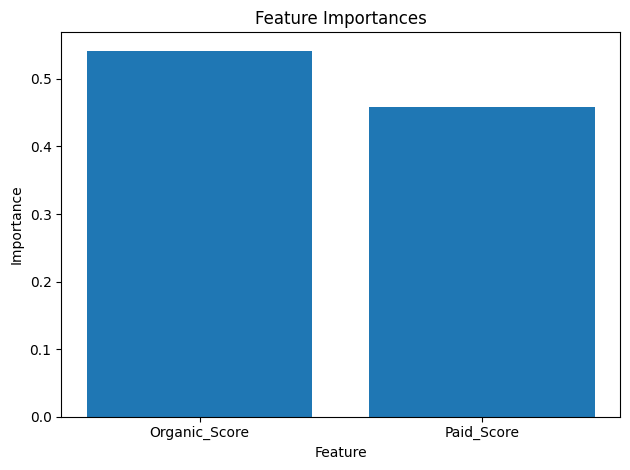

<ipython-input-19-63c900ce45e6>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

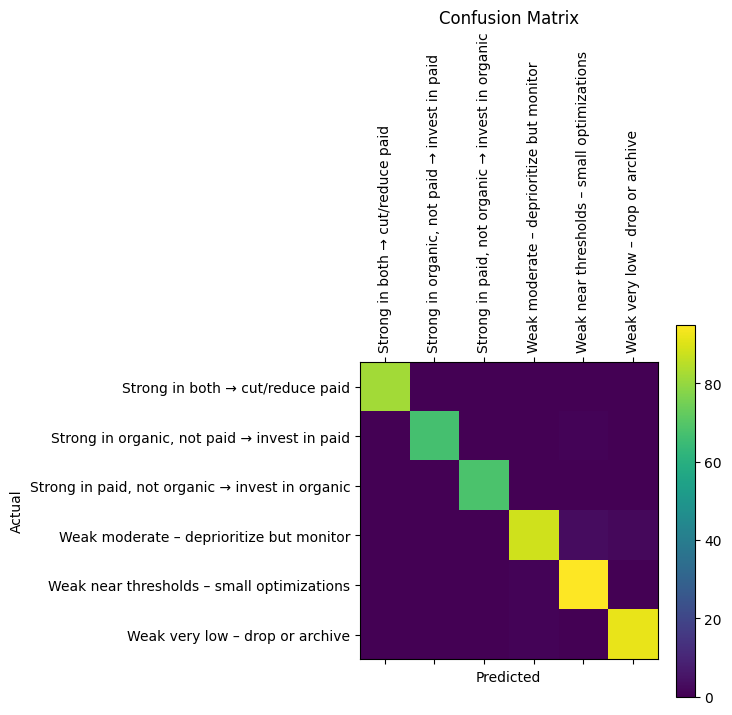

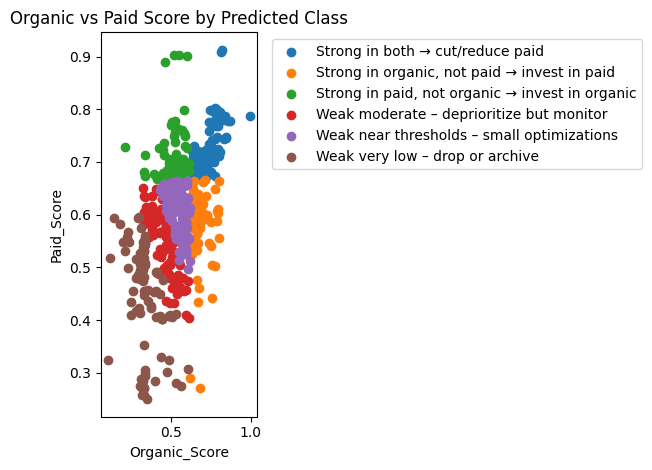

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assume clf, X_test, y_test, y_pred, X, y are already in your environment

# 1) Feature Importances Bar Chart
importances = clf.feature_importances_
labels = ['Organic_Score', 'Paid_Score']

plt.figure()
plt.bar(labels, importances)
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 2) Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

plt.figure()
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(range(len(clf.classes_)), clf.classes_, rotation=90)
plt.yticks(range(len(clf.classes_)), clf.classes_)
plt.colorbar()
plt.tight_layout()
plt.show()

# 3) Scatter Plot of Scores by Predicted Class
plt.figure()
for cls in np.unique(y_pred):
    mask = (y_pred == cls)
    plt.scatter(X_test.loc[mask, 'Organic_Score'],
                X_test.loc[mask, 'Paid_Score'],
                label=cls)
plt.title('Organic vs Paid Score by Predicted Class')
plt.xlabel('Organic_Score')
plt.ylabel('Paid_Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


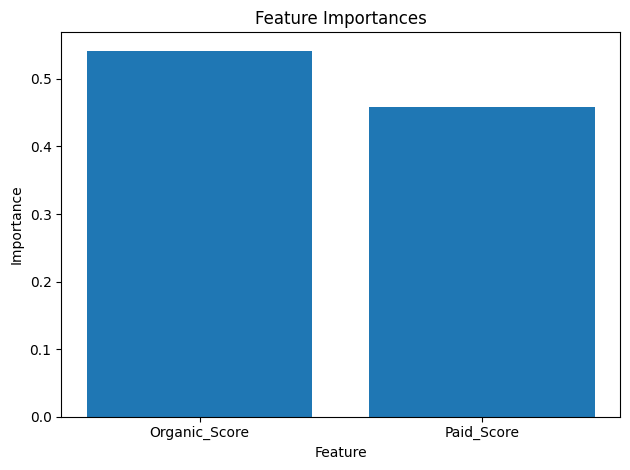

<ipython-input-20-cd553f571e72>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

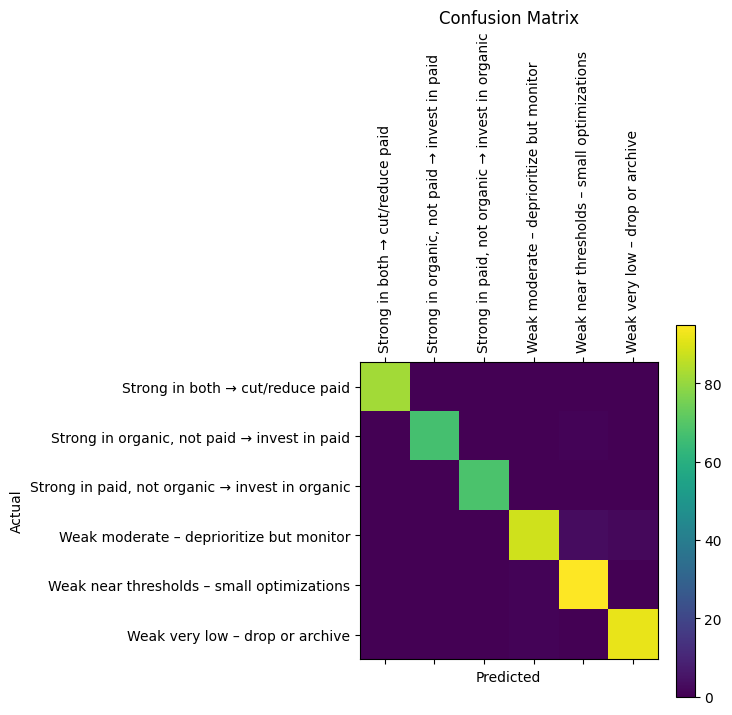

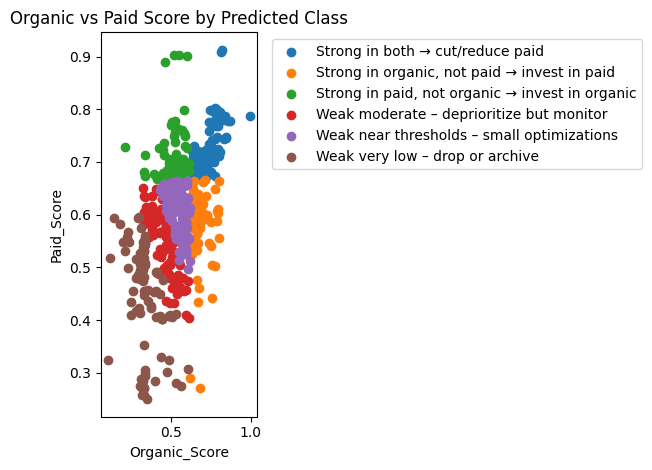

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix
# Load or reuse df_final with Organic_Score, Paid_Score, Business_Label_Final

# Prepare features & labels
X = df_final[['Organic_Score','Paid_Score']]
y = df_final['Business_Label_Final']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 1) Feature importances
plt.figure()
plt.bar(['Organic_Score','Paid_Score'], clf.feature_importances_)
plt.title('Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 2) Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure()
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(range(len(clf.classes_)), clf.classes_, rotation=90)
plt.yticks(range(len(clf.classes_)), clf.classes_)
plt.colorbar()
plt.tight_layout()
plt.show()

# 3) Scatter plot of predictions
plt.figure()
for cls in clf.classes_:
    mask = y_pred == cls
    plt.scatter(X_test.loc[mask, 'Organic_Score'],
                X_test.loc[mask, 'Paid_Score'],
                label=cls)
plt.title('Organic vs Paid Score by Predicted Class')
plt.xlabel('Organic_Score')
plt.ylabel('Paid_Score')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# 1) Group by label and list the keywords
kw_by_label = df_final.groupby('Business_Label_Final')['canonical_keyword_x'].apply(list)

for label, keywords in kw_by_label.items():
    print(f"\n=== {label} ({len(keywords)} keywords) ===")
    print(", ".join(keywords[:20]) + ("…" if len(keywords)>20 else ""))

# 2) (Optional) Save each group to its own CSV
for label, group in df_final.groupby('Business_Label_Final'):
    # Replace forward slashes and spaces with underscores to avoid creating subdirectories
    safe_label = label.replace(" → ","_").replace(" ", "_").replace("/", "_")[:30]
    filename = f"keywords_{safe_label}.csv"
    group.to_csv(filename, index=False)
    print(f"Saved {len(group)} rows to {filename}")


=== Strong in both → cut/reduce paid (274 keywords) ===
emergency response guidebook, placard, hazmat label, dot placard, hazard placard, label master, hazard label, un placard, labelmaster, hazard class 2, limited quantity label, hazard label, hazard class 2, dot placard, hazardous material placard, labelmaster, label master, dgr iata, emergency response guidebook, iata dangerous good regulation…

=== Strong in organic, not paid → invest in paid (226 keywords) ===
hazardous waste label, overpack label, hazmat online training, warehouse label, flammable placard, flammable label, erg book, explosive placard, dangerous good label, corrosive placard, corrosive label, dot hazmat label, dot hazmat placard, hazmat training, hazmat shipping label, dot label, dgr iata, shipping large lithium battery, hazmat placard, hazardous material label…

=== Strong in paid, not organic → invest in organic (226 keywords) ===
iata book, how to ship large lithium battery, dg software, labelmastercom, 49 cfr

In [ ]:
# 1) Define the columns you want to keep
cols_to_keep = [
    'canonical_keyword_x','TimePeriod',
    'Search Volume','Impressions_SEO',
    'Paid_Clicks','Paid_Impressions','Paid_CTR','Paid_Cost',
    'Organic_Score','Paid_Score','Business_Label_Final'
]

# 2) Subset your master DataFrame
df_export = df_final[cols_to_keep].copy()

# 3) Save the entire dataset to CSV
output_file = 'all_keywords_with_labels.csv'
df_export.to_csv(output_file, index=False)
print(f"Saved {len(df_export)} rows to {output_file}")


Saved 1665 rows to all_keywords_with_labels.csv


In [ ]:
 import pandas as pd

# 1) Group by label and list the keywords
kw_by_label = df_final.groupby('Business_Label_Final')['canonical_keyword_x'].apply(list)

for label, keywords in kw_by_label.items():
    print(f"\n=== {label} ({len(keywords)} keywords) ===")
    print(", ".join(keywords[:20]) + ("…" if len(keywords)>20 else ""))

# 2) (Optional) Save each group to its own CSV
for label, group in df_final.groupby('Business_Label_Final'):
    # Replace forward slashes and spaces with underscores to avoid creating subdirectories
    safe_label = label.replace(" → ","_").replace(" ", "_").replace("/", "_")[:30]
    filename = f"keywords_{safe_label}.csv"
    group.to_csv(filename, index=False)
    print(f"Saved {len(group)} rows to {filename}")


=== Strong in both → cut/reduce paid (274 keywords) ===
emergency response guidebook, placard, hazmat label, dot placard, hazard placard, label master, hazard label, un placard, labelmaster, hazard class 2, limited quantity label, hazard label, hazard class 2, dot placard, hazardous material placard, labelmaster, label master, dgr iata, emergency response guidebook, iata dangerous good regulation…

=== Strong in organic, not paid → invest in paid (226 keywords) ===
hazardous waste label, overpack label, hazmat online training, warehouse label, flammable placard, flammable label, erg book, explosive placard, dangerous good label, corrosive placard, corrosive label, dot hazmat label, dot hazmat placard, hazmat training, hazmat shipping label, dot label, dgr iata, shipping large lithium battery, hazmat placard, hazardous material label…

=== Strong in paid, not organic → invest in organic (226 keywords) ===
iata book, how to ship large lithium battery, dg software, labelmastercom, 49 cfr

<ipython-input-29-d6bcd5e84f88>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_org, labels=periods)


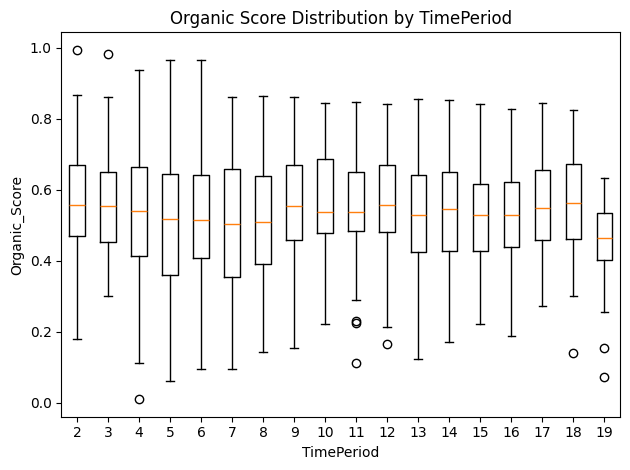

<ipython-input-29-d6bcd5e84f88>:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_paid, labels=periods)


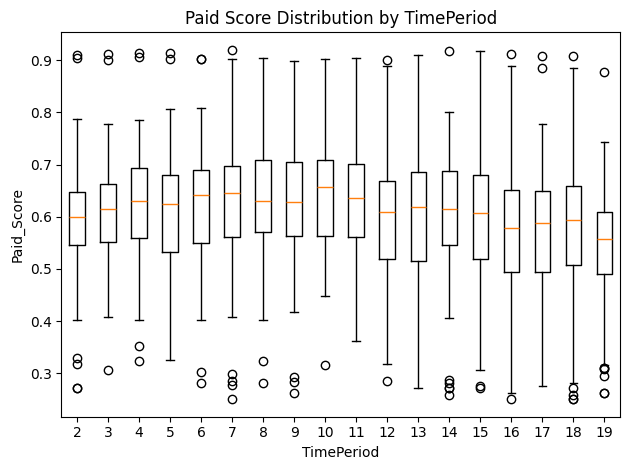

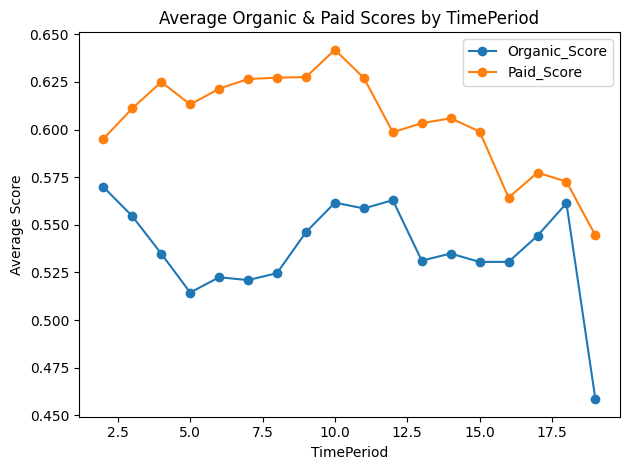

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume df_final is already in memory with the columns: canonical_keyword_x, TimePeriod, Organic_Score, Paid_Score

# 1) Boxplot: Organic Score by TimePeriod
periods = sorted(df_final['TimePeriod'].unique())
data_org = [df_final[df_final['TimePeriod'] == tp]['Organic_Score'] for tp in periods]

plt.figure()
plt.boxplot(data_org, labels=periods)
plt.title('Organic Score Distribution by TimePeriod')
plt.xlabel('TimePeriod')
plt.ylabel('Organic_Score')
plt.tight_layout()
plt.show()

# 2) Boxplot: Paid Score by TimePeriod
data_paid = [df_final[df_final['TimePeriod'] == tp]['Paid_Score'] for tp in periods]

plt.figure()
plt.boxplot(data_paid, labels=periods)
plt.title('Paid Score Distribution by TimePeriod')
plt.xlabel('TimePeriod')
plt.ylabel('Paid_Score')
plt.tight_layout()
plt.show()

# 3) Line plot: Average scores per TimePeriod
avg_scores = df_final.groupby('TimePeriod')[['Organic_Score', 'Paid_Score']].mean()

plt.figure()
plt.plot(avg_scores.index, avg_scores['Organic_Score'], marker='o', label='Organic_Score')
plt.plot(avg_scores.index, avg_scores['Paid_Score'],    marker='o', label='Paid_Score')
plt.title('Average Organic & Paid Scores by TimePeriod')
plt.xlabel('TimePeriod')
plt.ylabel('Average Score')
plt.legend()
plt.tight_layout()
plt.show()


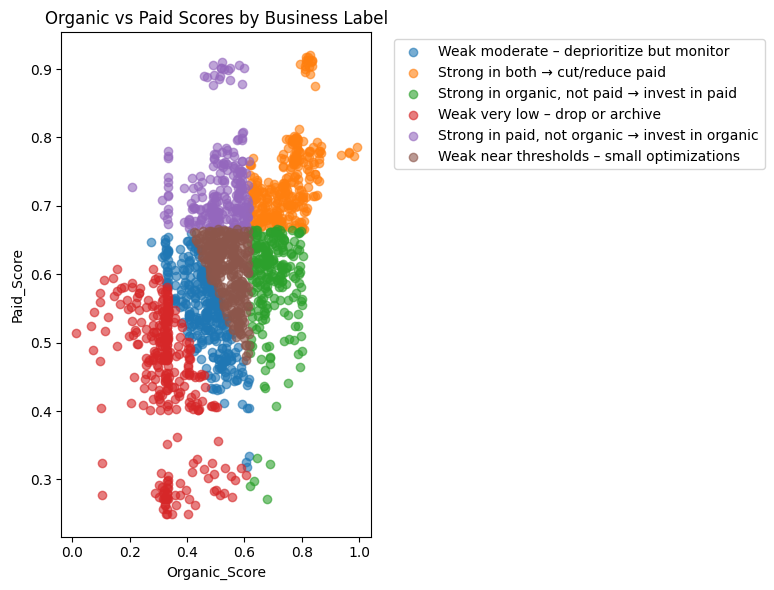

<ipython-input-30-7ae075552d4f>:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(org_data, labels=labels, vert=False)
<ipython-input-30-7ae075552d4f>:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(paid_data, labels=labels, vert=False)


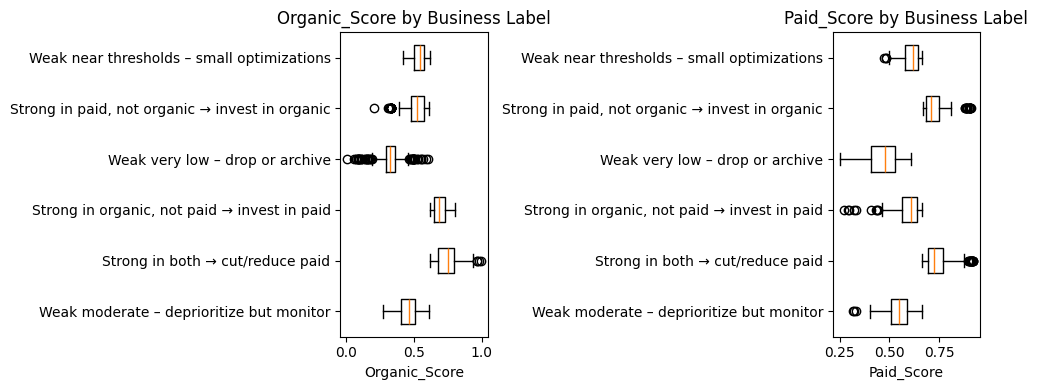

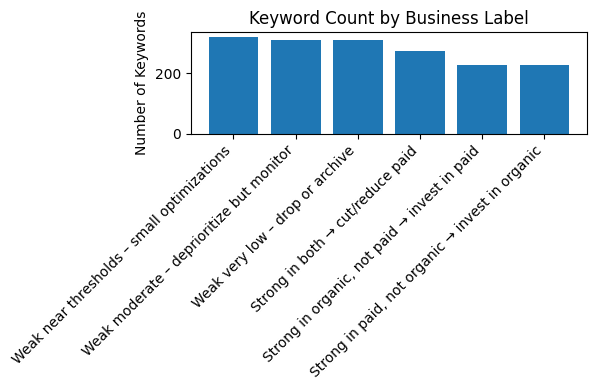

In [ ]:
import matplotlib.pyplot as plt

# 1) Scatter plot of Organic vs Paid, colored by label
plt.figure(figsize=(8,6))
for label in df_final['Business_Label_Final'].unique():
    subset = df_final[df_final['Business_Label_Final'] == label]
    plt.scatter(
        subset['Organic_Score'],
        subset['Paid_Score'],
        alpha=0.6,
        label=label
    )
plt.title('Organic vs Paid Scores by Business Label')
plt.xlabel('Organic_Score')
plt.ylabel('Paid_Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 2) Boxplots of each score by label
labels = df_final['Business_Label_Final'].unique()
org_data  = [df_final[df_final.Business_Label_Final==l]['Organic_Score'] for l in labels]
paid_data = [df_final[df_final.Business_Label_Final==l]['Paid_Score']    for l in labels]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(org_data, labels=labels, vert=False)
plt.title('Organic_Score by Business Label')
plt.xlabel('Organic_Score')

plt.subplot(1,2,2)
plt.boxplot(paid_data, labels=labels, vert=False)
plt.title('Paid_Score by Business Label')
plt.xlabel('Paid_Score')

plt.tight_layout()
plt.show()


# 3) Bar chart of counts per label
counts = df_final['Business_Label_Final'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Keyword Count by Business Label')
plt.ylabel('Number of Keywords')
plt.tight_layout()
plt.show()
